In [1]:
# Load libraries
import warnings
import numpy as np
import pandas as pd
import os

from collections import Counter
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler,label_binarize

from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_val_score, train_test_split
from sklearn.exceptions import ConvergenceWarning
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import classification_report, roc_curve, auc
import matplotlib.pyplot as plt
SEED = 90089

In [2]:
# disable deprecation warnings and convergence warning after production 
os.environ["PYTHONWARNINGS"] = "ignore::UserWarning"

### `LogisticRegression` Classifier on Hyperclygemic patients

In [3]:
# Read data
patient_df = pd.read_csv('../data/hyperglycemic_patients_w_bin_categories.csv', index_col=0)
patient_df = patient_df.drop(['los'], axis=1)

# Previewing data
print("Dataframe shape:   ", patient_df.shape)
print("Dataframe Features:", patient_df.columns)
patient_df.head()

Dataframe shape:    (13243, 26)
Dataframe Features: Index(['glucose_max', 'anchor_age', 'dod', 'gender', 'dbp_mean', 'sbp_mean',
       'glucose_mean', 'heart_rate_mean', 'spo2_mean', 'resp_rate_mean',
       'temperature_mean', 'apsiii', 'glucose_score', 'avg_bmi_value',
       'avg_sofa', 'admission_type', 'label', 'AMBULATORY OBSERVATION',
       'DIRECT EMER.', 'DIRECT OBSERVATION', 'ELECTIVE', 'EU OBSERVATION',
       'EW EMER.', 'OBSERVATION ADMIT', 'SURGICAL SAME DAY ADMISSION',
       'URGENT'],
      dtype='object')


,glucose_max,anchor_age,dod,gender,dbp_mean,sbp_mean,glucose_mean,heart_rate_mean,spo2_mean,resp_rate_mean,...,label,AMBULATORY OBSERVATION,DIRECT EMER.,DIRECT OBSERVATION,ELECTIVE,EU OBSERVATION,EW EMER.,OBSERVATION ADMIT,SURGICAL SAME DAY ADMISSION,URGENT
0,277.0,36,0,0,64.320000,112.880000,221.272727,101.800000,1.963788,1.239203,...,0,0,0,0,0,0,0,1,0,0
1,259.0,19,1,1,49.300000,74.200000,259.000000,89.750000,1.845098,1.420506,...,0,0,0,0,0,0,1,0,0,0
2,406.0,24,0,0,57.333333,92.848485,292.000000,86.631579,1.983004,1.184393,...,2,0,0,0,0,0,1,0,0,0
3,398.0,31,0,0,78.600000,133.800000,285.000000,100.826087,1.955709,1.400951,...,0,0,0,0,0,0,1,0,0,0
4,487.0,34,0,1,107.062500,164.437500,235.777778,77.000000,1.996731,1.398870,...,2,0,0,0,0,0,0,0,0,1


In [39]:
print("Null value in Feature set summary:\n",patient_df.isnull().sum(), "\n","--"*15)

Null value in Feature set summary:
 glucose_max                    0
anchor_age                     0
dod                            0
gender                         0
dbp_mean                       0
sbp_mean                       0
glucose_mean                   0
heart_rate_mean                0
spo2_mean                      0
resp_rate_mean                 0
temperature_mean               0
apsiii                         0
glucose_score                  0
avg_bmi_value                  0
avg_sofa                       0
admission_type                 0
label                          0
AMBULATORY OBSERVATION         0
DIRECT EMER.                   0
DIRECT OBSERVATION             0
ELECTIVE                       0
EU OBSERVATION                 0
EW EMER.                       0
OBSERVATION ADMIT              0
SURGICAL SAME DAY ADMISSION    0
URGENT                         0
dtype: int64 
 ------------------------------


### LR without `StandardScaler`

In [40]:
# Data split
X = patient_df.loc[:, patient_df.columns != 'label']
y = patient_df.iloc[:, -1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)

In [41]:
# Resample data to tackle class imbalance
oversample = SMOTE()
X_sampled, y_sampled = oversample.fit_resample(X_train, y_train)

# summarize the resampled label distribution
counter = Counter(y_sampled)
print(counter)

ValueError: could not convert string to float: 'EW EMER.'

In [42]:
# Tune model with stratifiedKFold cross validation
lr = LogisticRegression(random_state=SEED)

parameters = {
    'penalty' : ['l1', 'l2'],
    'C'       : [0.1, 1, 10],
    'solver'  : ['liblinear', 'saga'], 
    'max_iter': [500, 1000]}
grid_lr = GridSearchCV(lr, parameters, cv=5, n_jobs=8)
grid_lr.fit(X_sampled, y_sampled)

NameError: name 'X_sampled' is not defined

In [43]:
print("----         Results from Grid Search           ---")
print("\n The best estimator across ALL searched params:\n", grid_lr.best_estimator_)
print("\n The best parameters across ALL searched params:\n", grid_lr.best_params_)

----         Results from Grid Search           ---


AttributeError: 'GridSearchCV' object has no attribute 'best_estimator_'

In [44]:
best_lr = LogisticRegression(C=1,
                            penalty='l1',
                            solver='liblinear',
                            random_state=SEED,
                            max_iter=500,
                            n_jobs=8)

In [45]:
best_lr.fit(X_sampled, y_sampled)

NameError: name 'X_sampled' is not defined

In [23]:
print("Model Accuracy based on Testing dataset: {:.5f}".format(best_lr.score(X_test, y_test)))

Model Accuracy based on Testing dataset: 0.56777


### LR Model with `StandardScaler`

In [4]:
numerical_features = ['glucose_max', 'anchor_age', 'dbp_mean', 'sbp_mean',
       'glucose_mean', 'heart_rate_mean', 'spo2_mean', 'resp_rate_mean',
       'temperature_mean', 'apsiii', 'glucose_score', 'avg_sofa']


# Standardized variable for consistent measurement across numerical values
scaler = StandardScaler()
X_std = scaler.fit_transform(patient_df[numerical_features])

# Interpolate categorical variables
X_cat = patient_df[['gender', 'AMBULATORY OBSERVATION',
       'DIRECT EMER.', 'DIRECT OBSERVATION', 'ELECTIVE', 'EU OBSERVATION',
       'EW EMER.', 'OBSERVATION ADMIT', 'SURGICAL SAME DAY ADMISSION',
       'URGENT']]


X = np.concatenate([X_std, X_cat.to_numpy()], axis=1)
y = patient_df["label"]
print("X Standardized data Shape: ", X_std.shape)
print("X Categorical data shape:  ", X_cat.shape)
print("X, y shape:                ", X.shape, y.shape)

X Standardized data Shape:  (13243, 12)
X Categorical data shape:   (13243, 10)
X, y shape:                 (13243, 22) (13243,)


In [5]:
X_train_std, X_test_std, y_train_std, y_test_std = train_test_split(X, y, test_size=0.2, random_state=SEED)

In [6]:
counter = Counter(y_train_std)
print(counter)

Counter({0: 6585, 1: 2543, 2: 1466})


In [7]:
# Resample data to tackle class imbalance
oversample = SMOTE()
X_sampled_std, y_sampled_std = oversample.fit_resample(X_train_std, y_train_std)

# summarize the resampled label distribution
counter = Counter(y_sampled_std)
print(counter)

Counter({0: 6585, 1: 6585, 2: 6585})


In [40]:
lr_std = LogisticRegression(random_state=SEED)

parameters = {
    'penalty' : ['l1', 'l2'],
    'C'       : [0.1, 1, 10],
    'solver'  : ['liblinear', 'saga'], 
    'max_iter': [100, 500]}
grid_lr_std = GridSearchCV(lr_std, parameters, cv=5, n_jobs=6)
grid_lr_std.fit(X_sampled_std, y_sampled_std)

GridSearchCV(cv=5, estimator=LogisticRegression(random_state=90089), n_jobs=6,
             param_grid={'C': [0.1, 1, 10], 'max_iter': [100, 500],
                         'penalty': ['l1', 'l2'],
                         'solver': ['liblinear', 'saga']})

In [41]:
print("----         Results from Grid Search           ---")
print("\n The best estimator across ALL searched params:\n", grid_lr_std.best_estimator_)
print("\n The best parameters across ALL searched params:\n", grid_lr_std.best_params_)

----         Results from Grid Search           ---

 The best estimator across ALL searched params:
 LogisticRegression(C=0.1, penalty='l1', random_state=90089, solver='saga')

 The best parameters across ALL searched params:
 {'C': 0.1, 'max_iter': 100, 'penalty': 'l1', 'solver': 'saga'}


In [8]:
best_lr_std = LogisticRegression(C = 0.1,
                                penalty = 'l1',
                                solver = 'saga',
                                random_state=SEED,
                                max_iter=100, 
                                n_jobs=8)
best_lr_std.fit(X_sampled_std, y_sampled_std)

d:\miniconda3\envs\cv\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


LogisticRegression(C=0.1, n_jobs=8, penalty='l1', random_state=90089,
                   solver='saga')

In [9]:
print("Model Accuracy based on Testing dataset: {:.5f}".format(best_lr_std.score(X_test_std, y_test_std)))

Model Accuracy based on Testing dataset: 0.56625


In [10]:
y_pred = best_lr_std.predict(X_test_std)
print(classification_report(y_test_std, y_pred))

              precision    recall  f1-score   support

           0       0.80      0.64      0.71      1644
           1       0.32      0.33      0.32       635
           2       0.35      0.62      0.45       370

    accuracy                           0.57      2649
   macro avg       0.49      0.53      0.49      2649
weighted avg       0.62      0.57      0.58      2649



In [11]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_test_std, best_lr_std.predict_proba(X_test_std), multi_class='ovr')

0.7156322645298762

In [12]:
N_CLASSES = len(np.unique(patient_df.label))
y_train_encoded = label_binarize(y_train_std, classes=[0, 1, 2])
y_test_encoded = label_binarize(y_test_std, classes=[0, 1, 2])

# lr_clf = RandomForestClassifier(n_estimators=200, 
#                                 min_samples_split=5,
#                                 min_samples_leaf=1,
#                                 max_features='log2',
#                                 max_depth=20,
#                                 random_state=SEED,
#                                 n_jobs=4)

ovr_clf = OneVsRestClassifier(best_lr_std, n_jobs=2)

y_score_encoded = ovr_clf.fit(X_train_std, y_train_encoded).predict_proba(X_test_std)

# false-positive, and true-positive rate
fp_rate, tp_rate = dict(), dict()
roc_auc = dict()

for c in range(N_CLASSES):
    fp_rate[c], tp_rate[c], _ = roc_curve(y_test_encoded[:, c], y_score_encoded[:, c])
    roc_auc[c] = auc(fp_rate[c], tp_rate[c])

# compute micro-average ROC curve & area in each area.

fp_rate['micro'], tp_rate['micro'], _ = roc_curve(y_test_encoded.ravel(), y_score_encoded.ravel())
roc_auc["micro"] = auc(fp_rate['micro'], tp_rate['micro'])

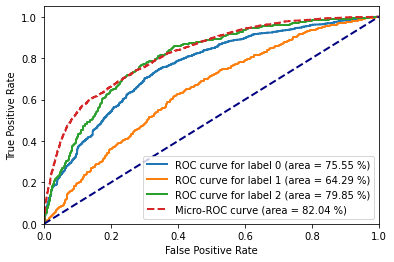

In [13]:
plt.figure()
lw = 2

for c in range(N_CLASSES):
    plt.plot(
        fp_rate[c],
        tp_rate[c],
        lw=lw,
        label="ROC curve for label %0.f (area = %0.2f %%)" %(c, roc_auc[c]*100),
    )

plt.plot(
        fp_rate['micro'],
        tp_rate['micro'],
        linestyle='dashed',
        lw=lw,
        label="Micro-ROC curve (area = %0.2f %%)" %(roc_auc['micro']*100),
    )

plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.show()

In [17]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

y_score = ovr_clf.decision_function(X_test_std)
# For each class
precision = dict()
recall = dict()
average_precision = dict()
for i in range(N_CLASSES):
    precision[i], recall[i], _ = precision_recall_curve(y_test_encoded[:, i], y_score[:, i])
    average_precision[i] = average_precision_score(y_test_encoded[:, i], y_score[:, i])

# A "micro-average": quantifying score on all classes jointly
precision["micro"], recall["micro"], _ = precision_recall_curve(
    y_test_encoded.ravel(), y_score.ravel()
)
average_precision["micro"] = average_precision_score(y_test_encoded, y_score, average="micro")

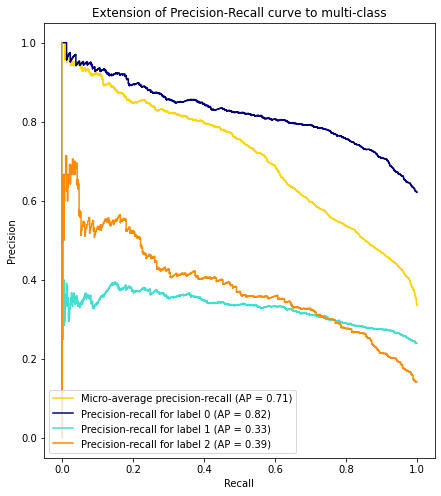

In [18]:
from sklearn.metrics import PrecisionRecallDisplay
from itertools import cycle

colors = cycle(["navy", "turquoise", "darkorange", "cornflowerblue", "teal"])
_, ax = plt.subplots(figsize=(7, 8))
display = PrecisionRecallDisplay(
    recall=recall["micro"],
    precision=precision["micro"],
    average_precision=average_precision["micro"],
)
display.plot(ax=ax, name="Micro-average precision-recall", color="gold")
ax.set_title("Extension of Precision-Recall curve to multi-class")
for i, color in zip(range(N_CLASSES), colors):
    display = PrecisionRecallDisplay(
        recall=recall[i],
        precision=precision[i],
        average_precision=average_precision[i],
    )
    display.plot(ax=ax, name=f"Precision-recall for label {i}", color=color)